<a href="https://colab.research.google.com/github/harrynguyen14/stock_price/blob/main/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
import tensorflow as tf

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

#ETL

In [2]:
data = pd.read_csv('/content/drive/MyDrive/REER/HPG.csv')

In [3]:
df = pd.DataFrame(data)

In [4]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-12-14,2587.906982,2616.661377,2616.661377,2616.661377,2616.661377,2825957.0
1,2007-12-17,2616.661377,2587.906982,2587.906982,2587.906982,2587.906982,3033217.0
2,2007-12-18,2587.906982,2659.793213,2659.793213,2659.793213,2659.793213,3622350.0
3,2007-12-19,2731.679443,2789.188477,2789.188477,2789.188477,2789.188477,7559115.0
4,2007-12-20,2789.188477,2702.925049,2702.925049,2702.925049,2702.925049,3652588.0
5,2007-12-21,2659.793213,2702.925049,2702.925049,2702.925049,2702.925049,3969065.0
6,2007-12-24,2746.056641,2731.679443,2731.679443,2731.679443,2731.679443,5804961.0
7,2007-12-25,2731.679443,2702.925049,2702.925049,2702.925049,2702.925049,3806653.0
8,2007-12-26,2616.661377,2702.925049,2702.925049,2702.925049,2702.925049,5483607.0
9,2007-12-27,2702.925049,2702.925049,2702.925049,2702.925049,2702.925049,2994273.0


In [5]:
df.drop(['Open', 'High', 'Low'], axis=1, inplace=True)

In [6]:
#df.rename(columns={'Adj Close': 'Price'}, inplace=True)

In [7]:
df.head()

,Date,Close,Adj Close,Volume
0,2007-12-14,2616.661377,2616.661377,2825957.0
1,2007-12-17,2587.906982,2587.906982,3033217.0
2,2007-12-18,2659.793213,2659.793213,3622350.0
3,2007-12-19,2789.188477,2789.188477,7559115.0
4,2007-12-20,2702.925049,2702.925049,3652588.0


In [8]:
df.tail()

,Date,Close,Adj Close,Volume
4299,2024-07-03,28750.0,28750.0,19520980.0
4300,2024-07-04,28700.0,28700.0,9373180.0
4301,2024-07-05,28650.0,28650.0,15620620.0
4302,2024-07-08,28800.0,28800.0,19549360.0
4303,2024-07-09,28950.0,28950.0,17032325.0


In [9]:
df.isnull().sum()

Date           0
Close        203
Adj Close    203
Volume       203
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df.dropna(subset=['Adj Close', 'Volume', 'Close'], inplace=True)

In [12]:
df.isnull().sum()

Date         0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [13]:
df['Adj Close'] = round(df['Adj Close'] / 1000 , 2)

In [14]:
df['Close'] = round(df['Close'] / 1000 , 2)

In [15]:
df['Volume'].astype(int)

0        2825957
1        3033217
2        3622350
3        7559115
4        3652588
          ...   
4299    19520980
4300     9373180
4301    15620620
4302    19549360
4303    17032325
Name: Volume, Length: 4101, dtype: int64

In [16]:
df.shape

(4101, 4)

In [17]:
df.head()

,Date,Close,Adj Close,Volume
0,2007-12-14,2.62,2.62,2825957.0
1,2007-12-17,2.59,2.59,3033217.0
2,2007-12-18,2.66,2.66,3622350.0
3,2007-12-19,2.79,2.79,7559115.0
4,2007-12-20,2.70,2.70,3652588.0


In [18]:
df.tail()

,Date,Close,Adj Close,Volume
4299,2024-07-03,28.75,28.75,19520980.0
4300,2024-07-04,28.70,28.70,9373180.0
4301,2024-07-05,28.65,28.65,15620620.0
4302,2024-07-08,28.80,28.80,19549360.0
4303,2024-07-09,28.95,28.95,17032325.0


In [19]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace = True)

In [20]:
df.head()

,Close,Adj Close,Volume
Date,,,
2007-12-14,2.62,2.62,2825957.0
2007-12-17,2.59,2.59,3033217.0
2007-12-18,2.66,2.66,3622350.0
2007-12-19,2.79,2.79,7559115.0
2007-12-20,2.70,2.70,3652588.0


In [21]:
df.describe()

,Close,Adj Close,Volume
count,4101.000000,4101.000000,4.101000e+03
mean,9.794067,9.794067,1.849224e+07
std,9.647604,9.647604,1.576834e+07
min,0.940000,0.940000,1.693000e+03
25%,2.360000,2.360000,6.649791e+06
50%,5.270000,5.270000,1.465947e+07
75%,13.520000,13.520000,2.581270e+07
max,40.560000,40.560000,1.795558e+08


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4101 entries, 2007-12-14 to 2024-07-09
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      4101 non-null   float64
 1   Adj Close  4101 non-null   float64
 2   Volume     4101 non-null   float64
dtypes: float64(3)
memory usage: 128.2 KB


In [23]:
df_1 = df.copy()

In [24]:
df_1.head()

,Close,Adj Close,Volume
Date,,,
2007-12-14,2.62,2.62,2825957.0
2007-12-17,2.59,2.59,3033217.0
2007-12-18,2.66,2.66,3622350.0
2007-12-19,2.79,2.79,7559115.0
2007-12-20,2.70,2.70,3652588.0


In [25]:
df_1.tail()

,Close,Adj Close,Volume
Date,,,
2024-07-03,28.75,28.75,19520980.0
2024-07-04,28.70,28.70,9373180.0
2024-07-05,28.65,28.65,15620620.0
2024-07-08,28.80,28.80,19549360.0
2024-07-09,28.95,28.95,17032325.0


#Analysis

Visualization

Visual the close price to track its performance over time.

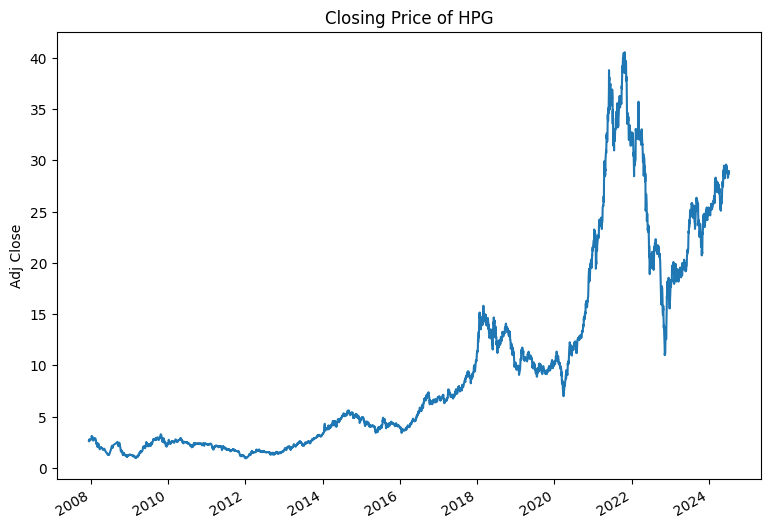

In [26]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)


plt.subplot(2, 2, 1)
df_1['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title("Closing Price of HPG")
plt.savefig('Closing_Price.png')
plt.tight_layout()

Trading volume, and changes to volume over the course of time

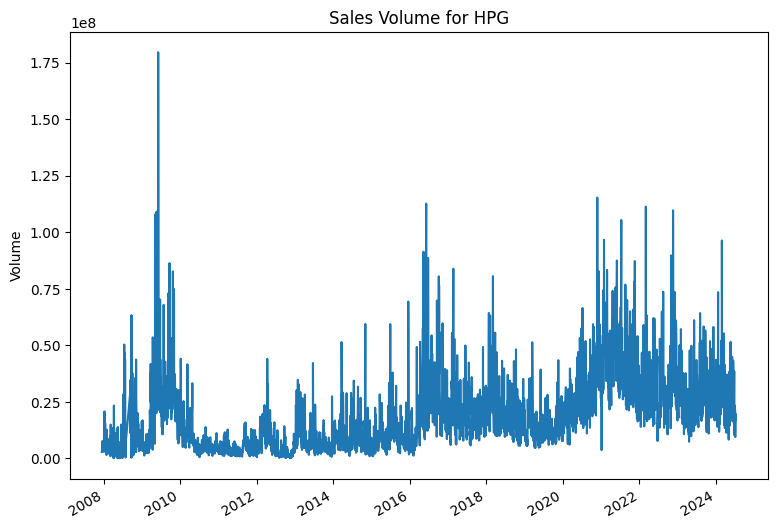

In [27]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)


plt.subplot(2, 2, 1)
df_1['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume for HPG")
plt.savefig('Volume.png')
plt.tight_layout()

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

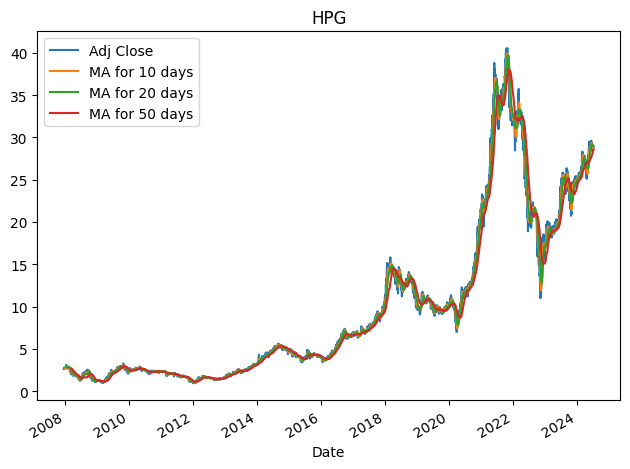

In [28]:
ma_day = [10, 20, 50]

for ma in ma_day:
    df_1[f'MA for {ma} days'] = df_1['Adj Close'].rolling(ma).mean()

df_1[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title('HPG')

plt.tight_layout()

In [29]:
# max_values = filtered_df.groupby('Date')['Adj Close'].max().reset_index()

# plt.figure(figsize=(10, 6))
# plt.plot(max_values['Date'], max_values['Adj Close'])
# plt.title('Maximum Adj Close per Year')
# plt.xlabel('Year')
# plt.ylabel('Maximum Value')
# plt.grid(True)
# plt.show()

In [30]:
# min_values = df_1.groupby('Date')['Adj Close'].min().reset_index()

# plt.figure(figsize=(10, 6))
# plt.plot(min_values['Date'], min_values['Adj Close'], marker="v")
# plt.title('Maximum Adj Close per Year')
# plt.xlabel('Year')
# plt.ylabel('Maximum Value')
# plt.grid(True)
# plt.show()

#Predict price

LSTM

In [31]:
df.head()

,Close,Adj Close,Volume
Date,,,
2007-12-14,2.62,2.62,2825957.0
2007-12-17,2.59,2.59,3033217.0
2007-12-18,2.66,2.66,3622350.0
2007-12-19,2.79,2.79,7559115.0
2007-12-20,2.70,2.70,3652588.0


In [32]:
df.drop(['Volume', 'Close'], axis=1, inplace=True)

In [33]:
df.shape

(4101, 1)

In [34]:
training_data_len = int(np.ceil( len(df) * .95 ))

training_data_len

3896

In [35]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

scaled_data

array([[0.04240283],
       [0.04164563],
       [0.04341242],
       ...,
       [0.69939425],
       [0.70318021],
       [0.70696618]])

In [36]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()


x_train, y_train = np.array(x_train), np.array(y_train)


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.04240283, 0.04164563, 0.04341242, 0.04669359, 0.04442201,
       0.04442201, 0.0451792 , 0.04442201, 0.04442201, 0.04442201,
       0.0451792 , 0.045684  , 0.0459364 , 0.04669359, 0.04770318,
       0.05098435, 0.05477032, 0.05401312, 0.05325593, 0.05325593,
       0.04946996, 0.05249874, 0.04896517, 0.05022716, 0.04896517,
       0.04669359, 0.04341242, 0.04366482, 0.04366482, 0.04416961,
       0.045684  , 0.04896517, 0.04745078, 0.04946996, 0.04896517,
       0.04669359, 0.04694599, 0.04669359, 0.04366482, 0.04341242,
       0.04013125, 0.03735487, 0.03508329, 0.03785967, 0.03584048,
       0.03659768, 0.03609288, 0.0345785 , 0.03180212, 0.02927814,
       0.02751136, 0.03003534, 0.03255931, 0.03508329, 0.0345785 ,
       0.03584048, 0.03609288, 0.03508329, 0.03205452, 0.02953054])]
[0.02953054013124684]

[array([0.04240283, 0.04164563, 0.04341242, 0.04669359, 0.04442201,
       0.04442201, 0.0451792 , 0.04442201, 0.04442201, 0.04442201,
       0.0451792 , 0.045684  , 0.04

In [37]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

3836/3836 [==============================] - 218s 55ms/step - loss: 9.1105e-04


In [38]:
test_data = scaled_data[training_data_len - 60: , :]

x_test = []

y_test = []
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

    y_test.append(test_data[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

7/7 [==============================] - 1s 29ms/step


25.959606099836087

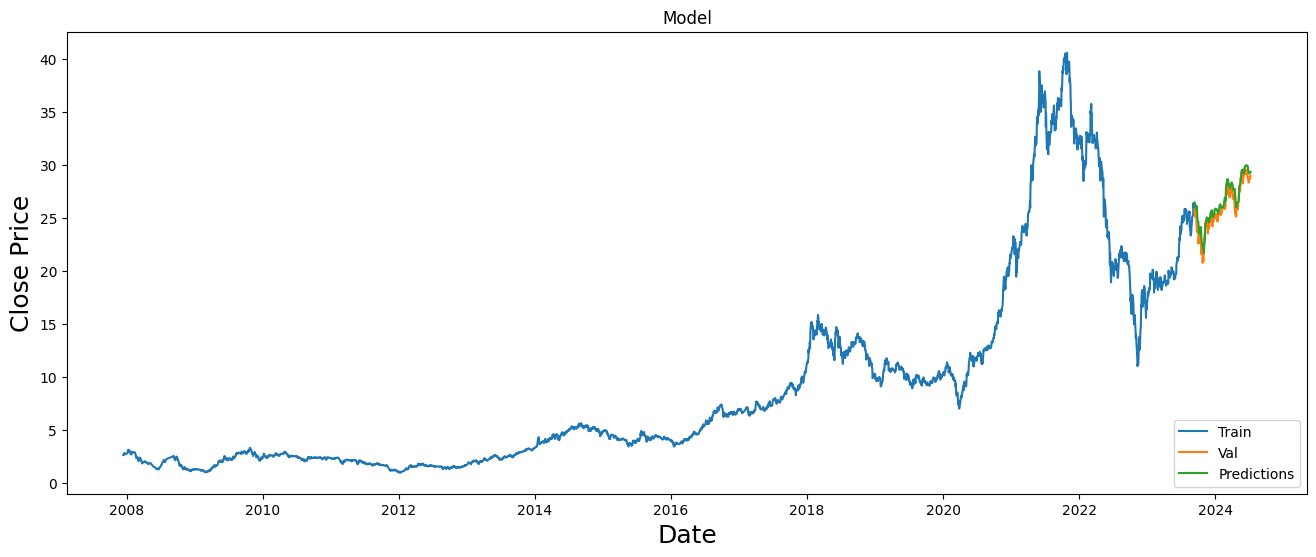

In [39]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid = valid.iloc[-len(predictions):]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [40]:
valid

,Adj Close,Predictions
Date,,
2023-09-13,25.82,26.439116
2023-09-14,25.27,26.409061
2023-09-15,25.09,26.240297
2023-09-18,25.09,26.020782
2023-09-19,25.59,25.839903
...,...,...
2024-07-03,28.75,29.147783
2024-07-04,28.70,29.196260
2024-07-05,28.65,29.244625


In [47]:
test_data = scaled_data[training_data_len - 10:, :]
x_test = []
y_test = data[training_data_len:]

for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Predict the future trend
future_data = df
last_60_days = future_data[-10:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
future_prediction = model.predict(X_test)
future_prediction = scaler.inverse_transform(future_prediction)
print('Predicted price for the next day:', future_prediction[0][0])

1/1 [==============================] - 0s 73ms/step
Predicted price for the next day: 28.60463


Predict price for next 10 days

In [48]:
# make predictions for the next 10 days
future_data = df
last_60_days = future_data[-60:]
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_prices = []
for i in range(10):
    predicted_price = model.predict(X_test)
    predicted_prices.append(predicted_price[0][0])
    X_test = np.append(X_test, [predicted_price], axis=1)

# invert the scaling
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

# print the predicted prices
print(predicted_prices)

1/1 [==============================] - 0s 57ms/step
[[29.379604]
 [29.547478]
 [29.749899]
 [29.963211]
 [30.17677 ]
 [30.386229]
 [30.59037 ]
 [30.789452]
 [30.984331]
 [31.176031]]
